## Bayesian Optimisation with Scikit-Optimize

In this notebook, we will use **Bayesian Optimization** to select the best **hyperparameters** for a Gradient Boosting Regressor, using the open source Python package [Scikit-Optimize](https://scikit-optimize.github.io/stable/index.html).

Scikit-Optimize offers an interface that allows us to do the Optimization in a similar way to the GridSearchCV or RandomizedSearchCV from Scikit-learn, through the class [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

#from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# note that we only need to import the wrapper
from skopt import BayesSearchCV

In [3]:
# load dataset
#boston_X, boston_y = load_boston(return_X_y=True)
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

boston_X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
boston_y = raw_df.values[1::2, 2]

X = pd.DataFrame(boston_X)
y = pd.Series(boston_y)

X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


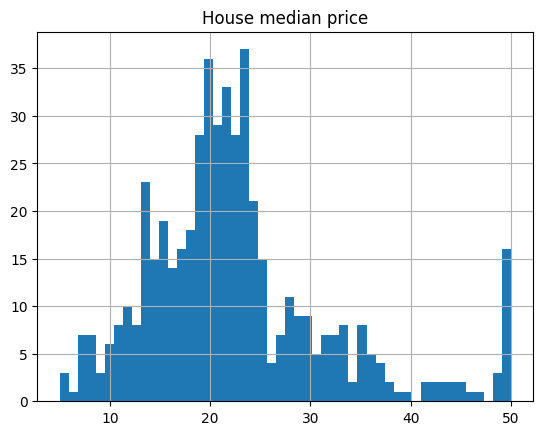

In [4]:
y.hist(bins=50)
plt.title("House median price")
plt.show()

In [5]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((354, 13), (152, 13))

## Define the model and Hyperparameter Space

In [6]:
# set up the model

gbm = GradientBoostingRegressor(random_state=0)

In [10]:
# hyperparameter space - note that we define it as 
# we would do for Scikit-learn classes

param_grid = {
    'n_estimators': (10, 120), 
    'min_samples_split': (0.001, 0.99, 'log-uniform'),
    'max_depth': (1, 8),
    'loss': ['quantile', 'huber', 'squared_error', 'absolute_error'],
}

In [11]:
# At the moment of creating this notebook, the BayesSearchCV is not
# compatible with sklearn version 0.24, because in this version the 
# param iid was deprecated from sklearn, and not yet from scikit-optimize

# make sure you have version 0.23 of sklearn to run this notebook
import sklearn
sklearn.__version__

'1.2.2'

## Bayesian Optimization

The rest of the notebook is very similar to that of RandomizedSearchCV, because the BayesSearchCV makes sure to bring forward all of Scikit-learn functionality.

In [12]:
# set up the search
search = BayesSearchCV(
    estimator=gbm,
    search_spaces=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_iter=50,
    random_state=10,
    n_jobs=4,
    refit=True)

# find best hyperparameters
search.fit(X_train, y_train)

BayesSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=0),
              n_jobs=4, random_state=10, scoring='neg_mean_squared_error',
              search_spaces={'loss': ['quantile', 'huber', 'squared_error',
                                      'absolute_error'],
                             'max_depth': (1, 8),
                             'min_samples_split': (0.001, 0.99, 'log-uniform'),
                             'n_estimators': (10, 120)})

In [13]:
# the best hyperparameters are stored in an attribute

search.best_params_

OrderedDict([('loss', 'absolute_error'),
             ('max_depth', 8),
             ('min_samples_split', 0.035704088383008085),
             ('n_estimators', 98)])

In [14]:
# the best score

search.best_score_

-11.633214827999758

In [15]:
# we also find the data for all models evaluated

results = pd.DataFrame(search.cv_results_)

print(results.shape)

results.head()

(50, 15)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.180332,0.004109,0.001333,0.000471,absolute_error,3,0.044228,80,"{'loss': 'absolute_error', 'max_depth': 3, 'mi...",-10.253658,-17.357468,-16.540711,-14.717279,3.173821,34
1,0.065003,0.007875,0.001655,0.000462,squared_error,2,0.308189,76,"{'loss': 'squared_error', 'max_depth': 2, 'min...",-11.740731,-18.260354,-14.708708,-14.903264,2.665178,35
2,0.124665,0.000471,0.001333,0.000471,quantile,3,0.002288,48,"{'loss': 'quantile', 'max_depth': 3, 'min_samp...",-29.208715,-42.190485,-36.790364,-36.063188,5.324671,49
3,0.130669,0.001247,0.001667,0.000471,squared_error,5,0.001897,90,"{'loss': 'squared_error', 'max_depth': 5, 'min...",-17.641456,-26.860518,-9.886990,-18.129655,6.938007,44
4,0.064690,0.001247,0.001333,0.000471,squared_error,4,0.054687,54,"{'loss': 'squared_error', 'max_depth': 4, 'min...",-11.734966,-26.734377,-11.014968,-16.494771,7.246459,40


Text(0.5, 0, 'Hyperparameter combinations')

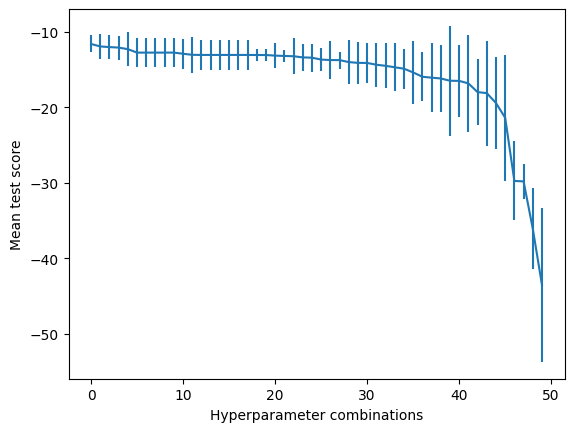

In [16]:
# we can order the different models based on their performance
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

# plot model performance and error

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [17]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

print('Train roc_auc: ', mean_squared_error(y_train, X_train_preds))
print('Test roc_auc: ', mean_squared_error(y_test, X_test_preds))

Train roc_auc:  1.7672575062085998
Test roc_auc:  17.267738953690085
